## Create Markov Chain Multi-touch-Attribution model

### Step 1: Construct the Transition Probability Matrix
As discussed above, the transition probability matrix contains the probabilities associated with moving from one state to another state. This is calculated using the data from all customer journeys.

In this step, we will:

- Define a user-defined function (UDF), get_transition_array, that takes a customer journey and enumerates each of the corresponding channel transitions
- Register the get_transition_array udf as a Spark UDF so that it can be utilized in Spark SQL
- Use get_transition_array to enumerate all channel transitions in a customer's journey
- Construct the transition probability matrix
- Validate that the state transition probabilities are calculated correctly
- Display the transition probability matrix

1.1 Define a user-defined function (UDF) that takes a customer journey and enumerates each of the corresponding channel transitions

In [6]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import *

spark = SparkSession.builder.appName('demo').getOrCreate()

In [2]:
def get_transition_array(path):
    
    state_transition_array = path.split(">")
    initial_state = state_transition_array[0]
  
    state_transitions = []
    for state in state_transition_array[1:]:
        state_transitions.append(initial_state.strip()+' > '+state.strip())
        initial_state =  state

    return state_transitions

In [7]:
#Register the get_transition_array udf as a Spark UDF so that it can be utilized in Spark SQL

spark.udf.register("get_transition_array", get_transition_array, ArrayType(StringType()))

<function __main__.get_transition_array(path)>

In [10]:
from minio import Minio
from sqlalchemy import create_engine

ACCESS_KEY = "DNPD2SAYLBELJ423HCNU"
SECRET_KEY = "zF7F6W93HS8vt+JKen4U17+zhcHiwH47AMuO3ap0"
PUBLIC_BUCKET = "shared-storage"

client = Minio(
    endpoint="minio-server.default.svc.cluster.local:9000",
    access_key=ACCESS_KEY,
    secret_key=SECRET_KEY,
    secure=False,
)

In [11]:
monthly_data_path = "/multi_touch_attribution/usr_journey_attribution_data.csv"

client.fget_object(
            PUBLIC_BUCKET,
            monthly_data_path,
            "usr_journey_attribution_data.csv",
        )

In [13]:
spark.read.option("header",True) \
          .csv("usr_journey_attribution_data.csv") \
          .createOrReplaceTempView("user_journey_view")

In [18]:
usr_journey_data = spark.sql("select * from user_journey_view")

In [20]:
usr_journey_data.toPandas().to_csv('usr_journey_view.csv')

### markov_state_transitions

Use the get_transition_array to enumerate all channel transitions in a customer's journey

In [33]:
spark.read.option("header",False) \
          .csv("usr_journey_view.csv") \
          .withColumnRenamed("_c1", "uid").withColumnRenamed("_c2", "path").withColumnRenamed("_c3", "first_interaction").withColumnRenamed("_c4", "last_interaction").withColumnRenamed("_c5", "conversion").withColumnRenamed("_c6", "visiting_order") \
          .createOrReplaceTempView("updated_user_journey_view")

In [35]:
spark.sql("select * from updated_user_journey_view").show()

+----+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
| _c0|                 uid|                path|   first_interaction|    last_interaction|conversion|      visiting_order|
+----+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|null|0000427e4c974a9e9...|Start > Search En...|Search Engine Mar...|               Email|         0|  [1, 2, 3, 4, 5, 6]|
|   0|00007b54c06247dea...|Start > Google Di...|Google Display Ne...|          Affiliates|         0|        [1, 2, 3, 4]|
|   1|00010c1be74244eba...|Start > Affiliate...|          Affiliates|Google Display Ne...|         0|              [1, 2]|
|   2|00012725fdce4b08b...|Start > Affiliate...|          Affiliates|          Affiliates|         0|[1, 2, 3, 4, 5, 6...|
|   3|00013dd4f787470f8...|Start > Search En...|Search Engine Mar...|      Social Network|         0|[1, 2, 3, 4, 5, 6...|
|   4|0001a1c3d1

In [36]:
spark.sql("""CREATE OR REPLACE TEMPORARY VIEW markov_state_transitions AS
SELECT path,
  explode(get_transition_array(path)) as transition,
  1 AS cnt
FROM
  updated_user_journey_view""")

DataFrame[]

In [37]:
markov_data = spark.sql("select * from markov_state_transitions")
markov_data.show()

+--------------------+--------------------+---+
|                path|          transition|cnt|
+--------------------+--------------------+---+
|Start > Search En...|Start > Search En...|  1|
|Start > Search En...|Search Engine Mar...|  1|
|Start > Search En...|Social Network > ...|  1|
|Start > Search En...|Google Display Ne...|  1|
|Start > Search En...|Social Network > ...|  1|
|Start > Search En...|Search Engine Mar...|  1|
|Start > Search En...|        Email > Null|  1|
|Start > Google Di...|Start > Google Di...|  1|
|Start > Google Di...|Google Display Ne...|  1|
|Start > Google Di...|Search Engine Mar...|  1|
|Start > Google Di...|Search Engine Mar...|  1|
|Start > Google Di...|   Affiliates > Null|  1|
|Start > Affiliate...|  Start > Affiliates|  1|
|Start > Affiliate...|Affiliates > Goog...|  1|
|Start > Affiliate...|Google Display Ne...|  1|
|Start > Affiliate...|  Start > Affiliates|  1|
|Start > Affiliate...|Affiliates > Affi...|  1|
|Start > Affiliate...|Affiliates > Soci.

In [38]:
markov_data.write.option("header",True) \
 .csv("usr_journey_attrition_data/markov_state_transitions.csv")

In [ ]:
data_file = "/multi_touch_attribution/markov_state_transitions.csv"

client.fput_object(
    PUBLIC_BUCKET,
    data_file,
    'usr_journey_attrition_data/markov_state_transitions.csv/markov_state_transitions.csv'  
)

### Construct the transition probability matrix

In [39]:
spark.sql("""CREATE OR REPLACE TEMPORARY VIEW transition_matrix AS
SELECT
  left_table.start_state,
  left_table.end_state,
  left_table.total_transitions / right_table.total_state_transitions_initiated_from_start_state AS transition_probability
FROM
  (
    SELECT
      transition,
      sum(cnt) total_transitions,
      trim(SPLIT(transition, '>') [0]) start_state,
      trim(SPLIT(transition, '>') [1]) end_state
    FROM
      markov_state_transitions
    GROUP BY
      transition
    ORDER BY
      transition
  ) left_table
  JOIN (
    SELECT
      a.start_state,
      sum(a.cnt) total_state_transitions_initiated_from_start_state
    FROM
      (
        SELECT
          trim(SPLIT(transition, '>') [0]) start_state,
          cnt
        FROM
          markov_state_transitions
      ) AS a
    GROUP BY
      a.start_state
  ) right_table ON left_table.start_state = right_table.start_state
ORDER BY
  end_state DESC
""")

DataFrame[]

#### Validate that the state transition probabilities are calculated correctly
Sum of all the outgoing probabilities (edges) from any channel (state in the graph) should sum to 100%.

In [41]:
spark.sql("""SELECT start_state, round(sum(transition_probability),2) as transition_probability_sum 
FROM transition_matrix
GROUP BY start_state""").show()

+--------------------+--------------------------+
|         start_state|transition_probability_sum|
+--------------------+--------------------------+
|Search Engine Mar...|                       1.0|
|Google Display Ne...|                       1.0|
|               Email|                       1.0|
|          Affiliates|                       1.0|
|               Start|                       1.0|
|      Social Network|                       1.0|
+--------------------+--------------------------+



In [42]:
transition_matrix = spark.sql("select * from transition_matrix")
transition_matrix.show()

+--------------------+--------------------+----------------------+
|         start_state|           end_state|transition_probability|
+--------------------+--------------------+----------------------+
|      Social Network|      Social Network|   0.16106696161392717|
|Search Engine Mar...|      Social Network|   0.16367875189292425|
|               Email|      Social Network|   0.16752039461202808|
|          Affiliates|      Social Network|   0.16211034109973943|
|Google Display Ne...|      Social Network|   0.16384554214130065|
|               Start|      Social Network|   0.20271424942458835|
|      Social Network|Search Engine Mar...|   0.23301338626222529|
|Google Display Ne...|Search Engine Mar...|    0.2402172902746078|
|               Start|Search Engine Mar...|    0.2971972257076216|
|Search Engine Mar...|Search Engine Mar...|   0.23890655329069593|
|               Email|Search Engine Mar...|   0.23989755264655663|
|          Affiliates|Search Engine Mar...|    0.2347820765829

In [43]:
transition_matrix.write.option("header",True) \
 .csv("usr_journey_attrition_data/transition_matrix.csv")

In [ ]:
data_file = "/multi_touch_attribution/transition_matrix.csv"

client.fput_object(
    PUBLIC_BUCKET,
    data_file,
    'usr_journey_attrition_data/transition_matrix_data.csv/transition_matrix.csv'  
)

### Display the transition probability matrix

<AxesSubplot:xlabel='end_state', ylabel='start_state'>

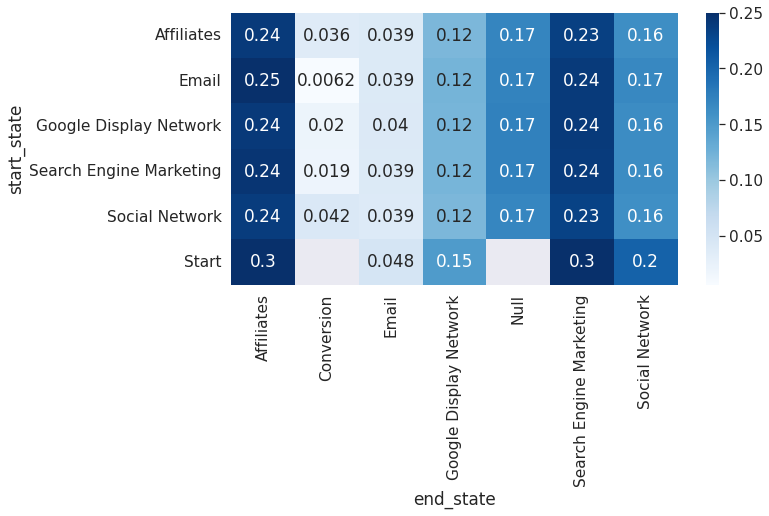

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
transition_matrix_pd = spark.table('transition_matrix').toPandas()
transition_matrix_pivot = transition_matrix_pd.pivot(index='start_state',columns='end_state',values='transition_probability')

plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(transition_matrix_pivot,cmap='Blues',vmax=0.25,annot=True)

## Calculate the Total Conversion Probability

In this step, we will:

- Define get_transition_probability_graph utility function
- Define calculate_conversion_probability utility function
- Calculate the Total Conversion Probability

In [45]:
def get_transition_probability_graph(removal_state = "null"):

    transition_probability_pandas_df = None

    # Get the transition probability graph without any states excluded if the removal_state is null
    if removal_state == "null":
        transition_probability_pandas_df = spark.sql('''select
            trim(start_state) as start_state,
            collect_list(end_state) as next_stages,
            collect_list(transition_probability) as next_stage_transition_probabilities
          from
            transition_matrix
          group by
            start_state''').toPandas()

    # Otherwise, get the transition probability graph with the specified channel excluded/removed
    else:
        transition_probability_pandas_df = spark.sql('''select
          sub1.start_state as start_state,
          collect_list(sub1.end_state) as next_stages,
          collect_list(transition_probability) as next_stage_transition_probabilities
          from
          (
            select
              trim(start_state) as start_state,
              case
                when end_state == \"'''+removal_state+'''\" then 'Null'
                else end_state
              end as end_state,
              transition_probability
            from
              transition_matrix
            where
              start_state != \"'''+removal_state+'''\"
          ) sub1 group by sub1.start_state''').toPandas()

    return transition_probability_pandas_df

In [46]:
transition_probability_pandas_df = get_transition_probability_graph()

In [52]:
transition_probability_pandas_df.to_csv('next_stage_transition_probability.csv')

In [53]:
data_file = "/multi_touch_attribution/next_stage_transition_probability.csv"

client.fput_object(
    PUBLIC_BUCKET,
    data_file,
    'next_stage_transition_probability.csv'  
)

### Define calculate_conversion_probability utility function

This utility function returns the total conversion probability based on the provided Transition Probability Matrix in pandas data frame format

In [54]:
def calculate_conversion_probability(transition_probability_pandas_df, calculated_state_conversion_probabilities, visited_states, current_state="Start"):
 
    if current_state=="Conversion":
        return 1.0

    elif (current_state=="Null") or (current_state in visited_states):
        return 0.0

    elif current_state in calculated_state_conversion_probabilities.keys():
        return calculated_state_conversion_probabilities[current_state]

    else:

        visited_states.add(current_state)

    current_state_transition_df = transition_probability_pandas_df.loc[transition_probability_pandas_df.start_state==current_state]

    next_states = current_state_transition_df.next_stages.to_list()[0]
    next_states_transition_probab = current_state_transition_df.next_stage_transition_probabilities.to_list()[0]

    current_state_conversion_probability_arr = []

    import copy
    for next_state, next_state_tx_probability in zip(next_states, next_states_transition_probab):
        current_state_conversion_probability_arr.append(next_state_tx_probability * calculate_conversion_probability(transition_probability_pandas_df, calculated_state_conversion_probabilities, copy.deepcopy(visited_states), next_state))

    calculated_state_conversion_probabilities[current_state] =  sum(current_state_conversion_probability_arr)

    return calculated_state_conversion_probabilities[current_state]

In [55]:
total_conversion_probability = calculate_conversion_probability(transition_probability_pandas_df, {}, visited_states=set(), current_state="Start")

In [56]:
total_conversion_probability

0.03802154134387996

### Use Removal Effect to Calculate Attribution
In this step, we will:

- Calculate the removal effect per channel
- Calculate conversion attribution per channel
- Register conversion_pandas_df as table to use SQL
- View channel attribution
- Merge channel attribution results into gold_attribution table

In [57]:
removal_effect_per_channel = {}
for channel in transition_probability_pandas_df.start_state.to_list():
    
    if channel!="Start":
        transition_probability_subset_pandas_df = get_transition_probability_graph(removal_state=channel)
        new_conversion_probability =  calculate_conversion_probability(transition_probability_subset_pandas_df, {}, visited_states=set(), current_state="Start")
        removal_effect_per_channel[channel] = round(((total_conversion_probability-new_conversion_probability)/total_conversion_probability), 2)

#### Calculate conversion attribution per channel

In [59]:
import pandas as pd
conversion_attribution={}
 
for channel in removal_effect_per_channel.keys():
    conversion_attribution[channel] = round(removal_effect_per_channel[channel] / sum(removal_effect_per_channel.values()), 2)

    channels = list(conversion_attribution.keys())
    conversions = list(conversion_attribution.values())

    conversion_pandas_df= pd.DataFrame({'attribution_model': 
                                    ['markov_chain' for _ in range(len(channels))], 
                                    'channel':channels, 
                                    'attribution_percent': conversions})


In [60]:
# Register 

sparkDF=spark.createDataFrame(conversion_pandas_df) 
sparkDF.createOrReplaceTempView("markov_chain_attribution_update")

In [61]:
markov_update = spark.sql("select * from markov_chain_attribution_update")
markov_update.show()

+-----------------+--------------------+-------------------+
|attribution_model|             channel|attribution_percent|
+-----------------+--------------------+-------------------+
|     markov_chain|Search Engine Mar...|               0.22|
|     markov_chain|Google Display Ne...|               0.13|
|     markov_chain|               Email|               0.02|
|     markov_chain|          Affiliates|               0.37|
|     markov_chain|      Social Network|               0.25|
+-----------------+--------------------+-------------------+



In [62]:
markov_update.write.option("header",True) \
 .csv("usr_journey_attrition_data/markov_chain_attribution_update.csv")

In [ ]:
data_file = "/multi_touch_attribution/markov_chain_attribution_update.csv"

client.fput_object(
    PUBLIC_BUCKET,
    data_file,
    'usr_journey_attrition_data/markov_chain_attribution_update.csv/markov_chain_attribution_update.csv'  
)

### Compare Channel Performance Across Methods

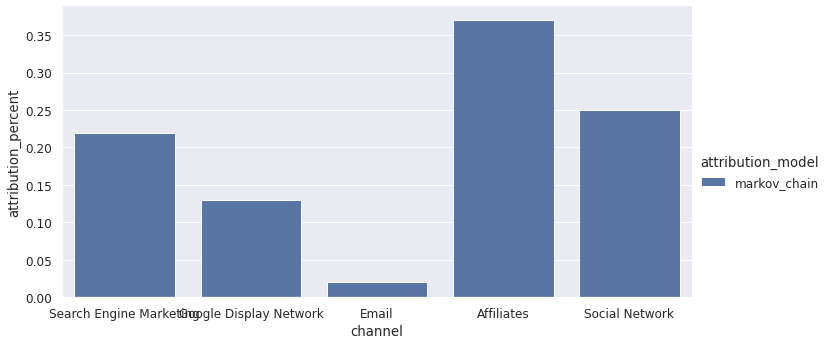

In [65]:
attribution_pd = spark.table('markov_chain_attribution_update').toPandas()
 
sns.set(font_scale=1.1)
sns.catplot(x='channel',y='attribution_percent',hue='attribution_model',data=attribution_pd, kind='bar', aspect=2)